<a href="https://colab.research.google.com/github/muhammadaarif-9/huggingface/blob/main/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements(is_chapter2=True)

# The Dataset

To build our emotion detector we'll use a great dataset from an article that explored how emotions are represented in English Twitter messages.footnote:[E. Saravia et al., "CARER: Contextualized Affect Representations for Emotion Recognition," Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (Oct–Nov 2018): 3687–3697, http://dx.doi.org/10.18653/v1/D18-1404.] Unlike most sentiment analysis datasets that involve just "positive" and "negative" polarities, this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet, our task will be to train a model that can classify it into one of these emotions.

# A First Look at Hugging Face Datasets

In [2]:
#!pip install datasets
from datasets import list_datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 7741 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/home/mohdarif.p/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
len(train_ds)

16000

or access a single example by its index:

In [7]:
train_ds[1]

{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'label': 0}

Here we see that a single row is represented as a dictionary, where the keys correspond to the column names:

In [8]:
train_ds.column_names

['text', 'label']

and the values are the tweet and the emotion. This reflects the fact that hugging face Datasets is based on Apache Arrow, which defines a typed columnar format that is more memory efficient than native Python. We can see what data types are being used under the hood by accessing the features attribute of a Dataset object:

In [9]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In this case, the data type of the text column is string, while the label column is a special ClassLabel object that contains information about the class names and their mapping to integers. We can also access several rows with a slice:

In [10]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


Note that in this case, the dictionary values are now lists instead of individual elements. We can also get the full column by name:

In [11]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


Now that we've seen how to load and inspect data with huggingface Datasets, let's do a few sanity checks about the content of our tweets.

#What If My Dataset Is Not on the Hub?

We'll be using the Hugging Face Hub to download datasets for most of the examples in this book. But in many cases, you'll find yourself working with data that is either stored on your laptop or on a remote server in your organization. huggingface Datasets provides several loading scripts to handle local and remote datasets. Examples for the most common data formats are shown below

|======
| Data format | Loading script | Example
| CSV | `csv` | `load_dataset("csv", data_files="my_file.csv")` 
| Text | `text` | `load_dataset("text", data_files="my_file.txt")` 
| JSON | `json` | `load_dataset("json", data_files="my_file.jsonl")` 

|======

As you can see for each data format, we just need to pass the relevant loading script to the load_dataset() function, along with a data_files argument that specifies the path or URL to one or more files. For example, the source files for the emotion dataset are actually hosted on Dropbox, so an alternative way to load the dataset is to first download one of the splits:



In [12]:
#hide_output
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
!wget {dataset_url}

--2022-07-26 12:37:06--  https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/1pzkadrvffbqw6o/train.txt [following]
--2022-07-26 12:37:07--  https://www.dropbox.com/s/raw/1pzkadrvffbqw6o/train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2983fbfb74b85eb088900f55eb.dl.dropboxusercontent.com/cd/0/inline/Bpx8HNmgjARHYCNO03e8mU7jDD5_7h7GHn5MqFXLic_twmHYYl5b--N0QDFNU0OhCwi-D0kNJufnsRFZ97gAEZR8Z15fHJqQ6livH91koFF6ebpYARlc6z3KYL5uzWl5pVxYZLR3mU9ogxHx-plrs9BNnCJoW42D8MyaPILIA1crUQ/file# [following]
--2022-07-26 12:37:07--  https://uc2983fbfb74b85eb088900f55eb.dl.dropboxusercontent.com/cd/0/inline/Bpx8HNmgjARHYCNO03e8mU7jDD5_7h7GHn5MqFXLic_twmHYYl5b--N0QDFNU0OhCwi-D0kNJu

 if we peek at the first row of the train.txt file:

In [13]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


we can see that here are no column headers and each tweet and emotion are separated by a semicolon. Nevertheless, this is quite similar to a CSV file, so we can load the dataset locally by using the csv script and pointing the data_files argument to the train.txt file:

In [14]:
#hide_output
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", names=["text", "label"])

Using custom data configuration default-dcec48cfed59cfee


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/mohdarif.p/.cache/huggingface/datasets/csv/default-dcec48cfed59cfee/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Here we've also specified the type of delimiter and the names of the columns. An even simpler approach is to just point the data_files argument to the URL itself:

In [ ]:
#hide_output
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", names=["text", "label"])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a70389bc6b0a03f2/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

which will automatically download and cache the dataset. As we can see, the load_dataset() function is very versatile. it is recommend to check out the hugging face Datasets documentation to get a complete overview.

# From Datasets to DataFrames

Although huggingface Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a Dataset object to a Pandas DataFrame so we can access high-level APIs for data visualization. To enable the conversion, hugging face Datasets provides a set_format() method that allows us to change the output format of the Dataset. Note that this does not change the underlying data format (which is an Arrow table), and you can switch to another format later if needed:

In [15]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


As you can see, the column headers have been preserved and the first few rows match our previous views of the data. However, the labels are represented as integers, so let's use the int2str() method of the label feature to create a new column in our DataFrame with the corresponding label names:

In [16]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Before diving into building a classifier, let's take a closer look at the dataset. As Andrej Karpathy notes in his famous blog post "A Recipe for Training Neural Networks", becoming "one with the data" is an essential step for training great models!

# Looking at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one.

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

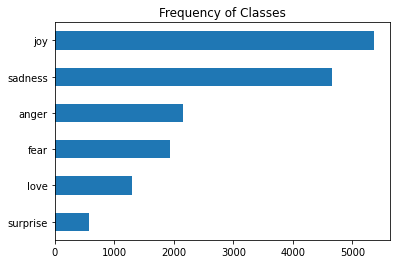

In [18]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the joy and sadness classes appear frequently, whereas love and surprise are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:

Randomly oversample the minority class.
Randomly undersample the majority class.
Gather more labeled data from the underrepresented classes.
To keep things simple in this chapter, we'll work with the raw, unbalanced class frequencies. If you want to learn more about these sampling techniques, we recommend checking out the Imbalanced-learn library. Just make sure that you don't apply sampling methods before creating your train/test splits, or you'll get plenty of leakage between them!

Now that we've looked at the classes, let's take a look at the tweets themselves.

# How Long Are Our Tweets?

Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:

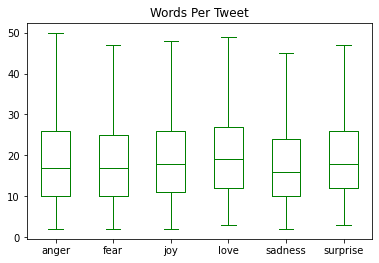

In [20]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="green")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue.

Let's now figure out how we can convert these raw texts into a format suitable for huggingface Transformers! While we're at it, let's also reset the output format of our dataset since we don't need the DataFrame format anymore:

In [22]:
emotions.reset_format()

# From Text to Tokens

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus. Before looking at the tokenizer used for DistilBERT, let's consider two extreme cases: character and word tokenization.

## ***Character Tokenization***

The simplest tokenization scheme is to feed each character individually to the model. In Python, str objects are really arrays under the hood, which allows us to quickly implement character-level tokenization with just one line of code:

In [36]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)
print(len(tokenized_text))

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']
38


This is a good start, but we're not done yet. Our model expects each character to be converted to an integer, a process sometimes called numericalization. One simple way to do this is by encoding each unique token (which are characters in this case) with a unique integer:

In [37]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)
print(len(token2idx))

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}
20


This gives us a mapping from each character in our vocabulary to a unique integer. We can now use token2idx to transform the tokenized text to a list of integers:

In [32]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)
print(len(input_ids))

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]
38


Each token has now been mapped to a unique numerical identifier (hence the name input_ids). The last step is to convert input_ids to a 2D tensor of one-hot vectors. One-hot vectors are frequently used in machine learning to encode categorical data, which can be either ordinal or nominal. For example, suppose we wanted to encode the names of characters in the Transformers TV series. One way to do this would be to map each name to a unique ID, as follows:

In [29]:
categorical_df = pd.DataFrame({"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


The problem with this approach is that it creates a fictitious ordering between the names, and neural networks are really good at learning these kinds of relationships. So instead, we can create a new column for each category and assign a 1 where the category is true, and a 0 otherwise. In Pandas, this can be implemented with the get_dummies() function as follows:

In [30]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


The rows of this DataFrame are the one-hot vectors, which have a single "hot" entry with a 1 and 0s everywhere else. Now, looking at our input_ids, we have a similar problem: the elements create an ordinal scale. This means that adding or subtracting two IDs is a meaningless operation, since the result is a new ID that represents another random token.

On the other hand, the result of adding two one-hot encodings can easily be interpreted: the two entries that are "hot" indicate that the corresponding tokens co-occur. We can create the one-hot encodings in PyTorch by converting input_ids to a tensor and applying the one_hot() function as follows:

In [47]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
#print(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
#print(one_hot_encodings)
one_hot_encodings.shape

/tmp/ipykernel_2293891/3808366311.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)


torch.Size([38, 20])

For each of the 38 input tokens we now have a one-hot vector with 20 dimensions, since our vocabulary consists of 20 unique characters.

Warning: It's important to always set num_classes in the one_hot() function because otherwise the one-hot vectors may end up being shorter than the length of the vocabulary (and need to be padded with zeros manually). In TensorFlow, the equivalent function is tf.one_hot(), where the depth argument plays the role of num_classes.

By examining the first vector, we can verify that a 1 appears in the location indicated by input_ids[0]:

In [48]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


From our simple example we can see that character-level tokenization ignores any structure in the text and treats the whole string as a stream of characters. Although this helps deal with misspellings and rare words, the main drawback is that linguistic structures such as words need to be learned from the data. This requires significant compute, memory, and data. For this reason, character tokenization is rarely used in practice. Instead, some structure of the text is preserved during the tokenization step. Word tokenization is a straightforward approach to achieve this, so let's take a look at how it works.

# ***Word Tokenization***

Instead of splitting the text into characters, we can split it into words and map each word to an integer. Using words from the outset enables the model to skip the step of learning words from characters, and thereby reduces the complexity of the training process.

One simple class of word tokenizers uses whitespace to tokenize the text. We can do this by applying Python's split() function directly on the raw text (just like we did to measure the tweet lengths):

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


From here we can take the same steps we took for the character tokenizer to map each word to an ID. However, we can already see one potential problem with this tokenization scheme: punctuation is not accounted for, so NLP. is treated as a single token. Given that words can include declinations, conjugations, or misspellings, the size of the vocabulary can easily grow into the millions!

note: Some word tokenizers have extra rules for punctuation. One can also apply stemming or lemmatization, which normalizes words to their stem (e.g., "great", "greater", and "greatest" all become "great"), at the expense of losing some information in the text.

Having a large vocabulary is a problem because it requires neural networks to have an enormous number of parameters. To illustrate this, suppose we have 1 million unique words and want to compress the 1-million-dimensional input vectors to 1-thousand-dimensional vectors in the first layer of our neural network. This is a standard step in most NLP architectures, and the resulting weight matrix of this first layer would contain 1 million  1 thousand = 1 billion weights. This is already comparable to the largest GPT-2 model,footnote:[GPT-2 is the successor of GPT, and it captivated the public's attention with its impressive ability to generate realistic text. We'll explore GPT-2 in detail in <>.] which has around 1.5 billion parameters in total!

Naturally, we want to avoid being so wasteful with our model parameters since models are expensive to train, and larger models are more difficult to maintain. A common approach is to limit the vocabulary and discard rare words by considering, say, the 100,000 most common words in the corpus. Words that are not part of the vocabulary are classified as "unknown" and mapped to a shared UNK token. This means that we lose some potentially important information in the process of word tokenization, since the model has no information about words associated with UNK.

Wouldn't it be nice if there was a compromise between character and word tokenization that preserved all the input information and some of the input structure? There is: subword tokenization.

## ***Subword Tokenization***

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is learned from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP, but let's start with WordPiece,footnote:[M. Schuster and K. Nakajima, "Japanese and Korean Voice Search," 2012 IEEE International Conference on Acoustics, Speech and Signal Processing (2012): 5149–5152, https://doi.org/10.1109/ICASSP.2012.6289079.] which is used by the BERT and DistilBERT tokenizers. The easiest way to understand how WordPiece works is to see it in action. huggingface Transformers provides a convenient AutoTokenizer class that allows you to quickly load the tokenizer associated with a pretrained model—we just call its from_pretrained() method, providing the ID of a model on the Hub or a local file path. Let's start by loading the tokenizer for DistilBERT:

In [ ]:
# !pip install transformers
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

The AutoTokenizer class belongs to a larger set of "auto" classes whose job is to automatically retrieve the model's configuration, pretrained weights, or vocabulary from the name of the checkpoint. This allows you to quickly switch between models, but if you wish to load the specific class manually you can do so as well. For example, we could have loaded the DistilBERT tokenizer as follows:

In [ ]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

note: When you run the AutoTokenizer.from_pretrained() method for the first time you will see a progress bar that shows which parameters of the pretrained tokenizer are loaded from the Hugging Face Hub. When you run the code a second time, it will load the tokenizer from the cache, usually located at ~/.cache/huggingface/.

Let's examine how this tokenizer works by feeding it our simple "Tokenizing text is a core task of NLP." example text:

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Just like we saw with character tokenization, we can see that the words have been mapped to unique integers in the input_ids field. We'll discuss the role of the attention_mask field in the next section. Now that we have the input_ids, we can convert them back into tokens by using the tokenizer's convert_ids_to_tokens() method:

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


We can observe three things here. First, some special [CLS] and [SEP] tokens have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence. Second, the tokens have each been lowercased, which is a feature of this particular checkpoint. Finally, we can see that "tokenizing" and "NLP" have been split into two tokens, which makes sense since they are not common words. The ## prefix in ##izing and ##p means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string. The AutoTokenizer class has a convert_tokens_to_string() method for doing just that, so let's apply it to our tokens:

In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


The AutoTokenizer class also has several attributes that provide information about the tokenizer. For example, we can inspect the vocabulary size:

In [ ]:
tokenizer.vocab_size

30522

and the corresponding model's maximum context size:

In [ ]:
tokenizer.model_max_length

512

Another interesting attribute to know about is the names of the fields that the model expects in its forward pass:

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Now that we have a basic understanding of the tokenization process for a single string, let's see how we can tokenize the whole dataset!

warning: When using pretrained models, it is really important to make sure that you use the same tokenizer that the model was trained with. From the model's perspective, switching the tokenizer is like shuffling the vocabulary. If everyone around you started swapping random words like "house" for "cat," you'd have a hard time understanding what was going on too!

# ***Tokenizing the Whole Dataset***

To tokenize the whole corpus, we'll use the map() method of our DatasetDict object. We'll encounter this method many times throughout this book, as it provides a convenient way to apply a processing function to each element in a dataset. As we'll soon see, the map() method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; padding=True will pad the examples with zeros to the size of the longest one in a batch, and truncation=True will truncate the examples to the model's maximum context size. To see tokenize() in action, let's pass a batch of two examples from the training set:

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Here we can see the result of padding: the first element of input_ids is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding [PAD] token in the vocabulary, and the set of special tokens also includes the [CLS] and [SEP] tokens that we encountered earlier:

In [ ]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Also note that in addition to returning the encoded tweets as input_ids, the tokenizer returns a list of attention_mask arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input.Figure Below provides a visual explanation of how the input IDs and attention masks are padded.

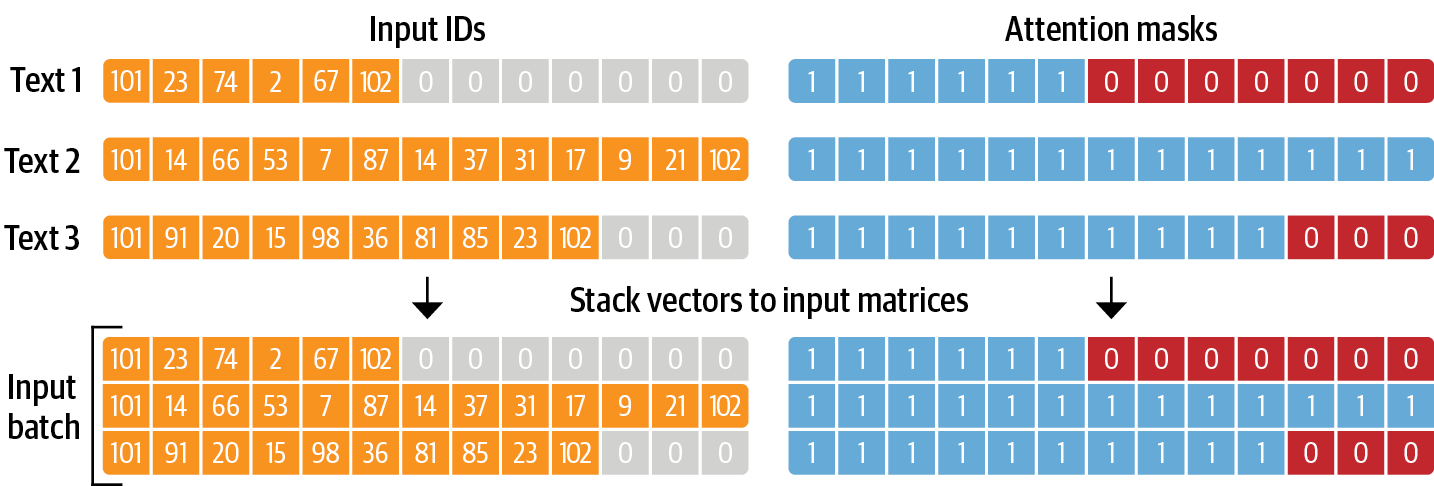


Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [ ]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we've set batch_size=None, our tokenize() function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new input_ids and attention_mask columns to the dataset:

In [ ]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


Note: In later chapters, we'll see how data collators can be used to dynamically pad the tensors in each batch. Padding globally will come in handy in the next section, where we extract a feature matrix from the whole corpus.

## ***Training a Text Classifier***

As discussed in chapter 1, models like DistilBERT are pretrained to predict masked words in a sequence of text. However, we can't use these language models directly for text classification; we need to modify them slightly. To understand what modifications are necessary, let's take a look at the architecture of an encoder-based model like DistilBERT, which is depicted in figure below.

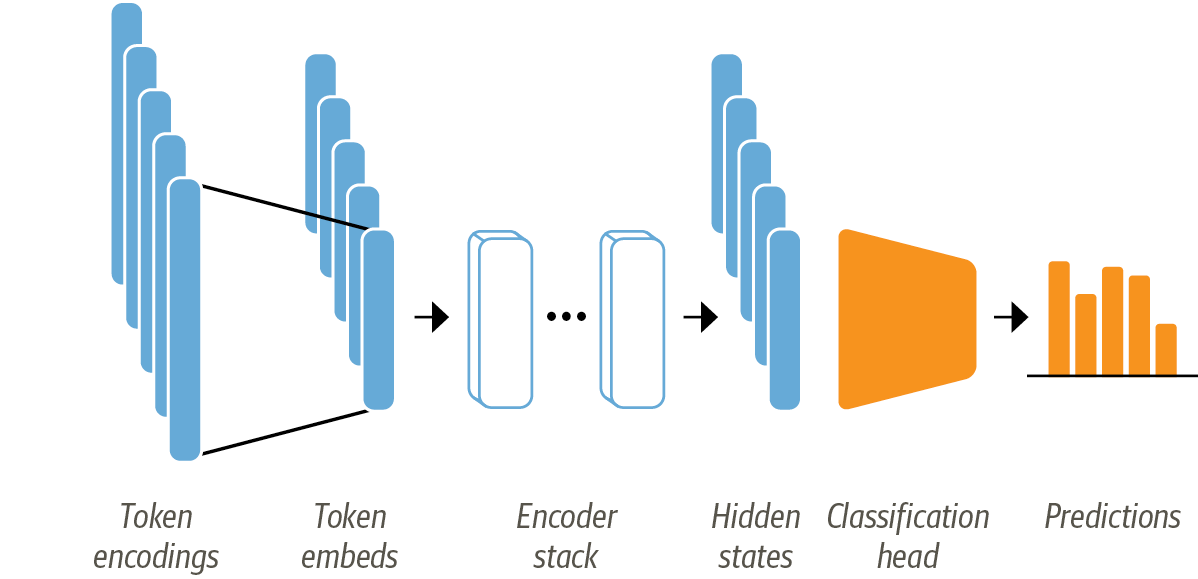

First, the text is tokenized and represented as one-hot vectors called token encodings. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens. Next, these token encodings are converted to token embeddings, which are vectors living in a lower-dimensional space. The token embeddings are then passed through the encoder block layers to yield a hidden state for each input token. For the pretraining objective of language modeling,⁠footnote:[In the case of DistilBERT, it's guessing the masked tokens.] each hidden state is fed to a layer that predicts the masked input tokens. For the classification task, we replace the language modeling layer with a classification layer.

note: In practice, PyTorch skips the step of creating one-hot vectors for token encodings because multiplying a matrix with a one-hot vector is the same as selecting a column from the matrix. This can be done directly by getting the column with the token ID from the matrix. We'll see this in chapter 3 when we use the nn.Embedding class.

We have two options to train such a model on our Twitter dataset:

Feature extraction:: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
Fine-tuning:: We train the whole model end-to-end, which also updates the parameters of the pretrained model.
In the following sections we explore both options for DistilBERT and examine their trade-offs.

## ***Transformers as Feature Extractors***

Using a transformer as a feature extractor is fairly simple. As shown in figure below, we freeze the body's weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

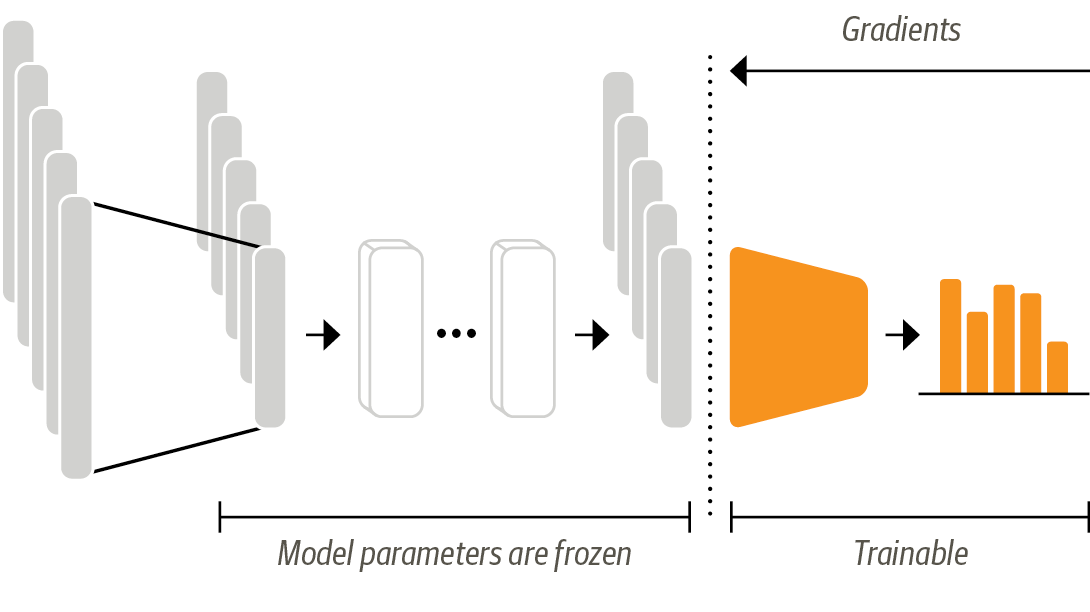

**Using pretrained models**

We will use another convenient auto class from huggingface Transformers called AutoModel. Similar to the AutoTokenizer class, AutoModel has a from_pretrained() method to load the weights of a pretrained model. Let's use this method to load the DistilBERT checkpoint:

In [ ]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Here we've used PyTorch to check whether a GPU is available or not, and then chained the PyTorch nn.Module.to() method to the model loader. This ensures that the model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.

The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

 **Interoperability Between Frameworks**

Although the code in this book is mostly written in PyTorch, huggingface Transformers provides tight interoperability with TensorFlow and JAX. This means that you only need to change a few lines of code to load a pretrained model in your favorite deep learning framework! For example, we can load DistilBERT in TensorFlow by using the TFAutoModel class as follows:


from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_ckpt)

This interoperability is especially useful when a model is only released in one framework, but you'd like to use it in another. For example, the XLM-RoBERTa model that we'll encounter in chapter 4 only has PyTorch weights, so if you try to load it in TensorFlow as we did before:

tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base")
you'll get an error. In these cases, you can specify a from_pt=True argument to the TfAutoModel.from_pretrained() function, and the library will automatically download and convert the PyTorch weights for you:

tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

As you can see, it is very simple to switch between frameworks in huggingface Transformers! In most cases, you can just add a "TF" prefix to the classes and you'll get the equivalent TensorFlow 2.0 classes. When we use the "pt" string (e.g., in the following section), which is short for PyTorch, just replace it with "tf", which is short for TensorFlow.



## ***Extracting the last hidden states***

To warm up, let's retrieve the last hidden states for a single string. The first thing we need to do is encode the string and convert the tokens to PyTorch tensors. This can be done by providing the return_tensors="pt" argument to the tokenizer as follows:

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [ ]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

As we can see, the resulting tensor has the shape [batch_size, n_tokens]. Now that we have the encodings as a tensor, the final step is to place them on the same device as the model and pass the inputs as follows:

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


Here we've used the torch.no_grad() context manager to disable the automatic calculation of the gradient. This is useful for inference since it reduces the memory footprint of the computations. Depending on the model configuration, the output can contain several objects, such as the hidden states, losses, or attentions, arranged in a class similar to a namedtuple in Python. In our example, the model output is an instance of BaseModelOutput, and we can simply access its attributes by name. The current model returns only one attribute, which is the last hidden state, so let's examine its shape:

In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])